In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

import os
import cv2
import matplotlib.pyplot as plt

In [29]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.002
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 5

In [30]:
DATADIR = r"/Users/shwetambari/Documents/VUMastersYear2/DeepLearning/Assignment_5/Aldaddin/imagenet/imagenette2-160/train"


CATEGORIES = ["n01440764", "n02102040", "n02979186", "n03000684", "n03028079", "n03394916",
              "n03417042", "n03425413", "n03445777", "n03888257"]
dataset = list()
categories = list()
categories_name = list()
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img))  
        dataset.append(img_array)
        if category=="n01440764":
            categories.append(0)
            categories_name.append(category)
        elif category=="n02102040":
            categories.append(1)
            categories_name.append(category)
        elif category=="n02979186":
            categories.append(2)
            categories_name.append(category)
        elif category=="n03000684":
            categories.append(3)
            categories_name.append(category)
        elif category=="n03028079":
            categories.append(4)
            categories_name.append(category)
        elif category=="n03394916":
            categories.append(5)
            categories_name.append(category)
        elif category=="n03417042":
            categories.append(6)
            categories_name.append(category)
        elif category=="n03425413":
            categories.append(7)
            categories_name.append(category)
        elif category=="n03445777":
            categories.append(8)
            categories_name.append(category)
        elif category=="n03888257":
            categories.append(9)
            categories_name.append(category)

9469

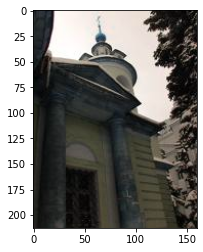

In [32]:
plt.imshow(dataset[3800])
len(dataset)

In [43]:
import torch.utils.data as data

class ImageFileset(data.Dataset):
    def __init__(self, flist, transform=None):
        self.imlist = flist
        self.transform = transform

    def __getitem__(self, index):
        img = self.imlist[index]
        if self.transform is not None:
              img = self.transform(img)

        return img

    def __len__(self):
        return len(self.imlist)

In [44]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(28,28)),
    transforms.ToTensor()])

In [45]:
trainset = ImageFileset(dataset,transform=transform)

In [46]:
train_data, valid_data = torch.utils.data.random_split(trainset, [6628,2841])

train_loader = torch.utils.data.DataLoader(train_data,batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=128, shuffle=True)

In [47]:
dataiter = iter(train_loader)
images = dataiter.next()
print(type(images))
print(images.shape)
#print(labels.shape)

<class 'torch.Tensor'>
torch.Size([128, 3, 28, 28])


In [48]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [49]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [50]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [51]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

In [53]:
for epoch in range(num_epochs):
    for batch_idx, (real) in enumerate(train_loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/5] Batch 0/52                       Loss D: 0.5554, loss G: 0.5124
Epoch [1/5] Batch 0/52                       Loss D: 0.0692, loss G: 4.9710
Epoch [2/5] Batch 0/52                       Loss D: 0.1297, loss G: 1.7354
Epoch [3/5] Batch 0/52                       Loss D: 0.1101, loss G: 2.1542
Epoch [4/5] Batch 0/52                       Loss D: 0.0730, loss G: 3.4550
